In [15]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

import pandas as pd
import openpyxl

import sys
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.insert(1, '../../../mri_sim')
sys.path.insert(1, '../../..')

sys.path.insert(0, '../../../mri_sim/SSFP')
from simulator import *

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    phi_quad = 360/N
    phase = phi_quad*n*n/2
    phase = phase%360
    #in degree
    return phase

#Off-resonance profile magnitude --> F-state magnitude 
def Fstate(M_transverse):
    F_Magnitude = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(M_transverse), axis = 0))/M_transverse.shape[0]
    # F_Magnitude = np.fft.fftshift(M_transverse)
    # F_Magnitude = np.fft.fft(F_Magnitude, axis = 0)/M_transverse.shape[-1]
    # F_Magnitude = np.fft.ifftshift(F_Magnitude)
    

    F_state = np.fft.fftfreq(M_transverse.shape[0], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_transverse.shape[0]
    
    return np.transpose(F_Magnitude), np.transpose(F_state)

#Add field inhomogeneous to model T2* effect (for F_number F-states, F_number = 6 --> 0,1,2...5 F-states
def AddfieldInhomogeneous(M_transverse, TR, TE, T2prime, off_resonance_f):
   
    #F-state
    F_state_magnitude, F_state = Fstate(M_transverse)
    F_state = np.round(F_state).astype(int) #round F-state all to integer 
    F_state_magnitude_inhomo = F_state_magnitude
    
    index = 0
    for i in F_state:
        #remove the empty state caused by taking 2 period off-res profile 
        if ((i%2) == 0):
            F = np.abs(-i//2) #the right F-state (all cast to positive)
            time = TE+ F *TR
            if (T2prime == 0):
                F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index]
            else:
                F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index] *np.exp(-time/T2prime)
        index = index + 1 
    #End
    

#     #inverse fft get the off-res profile again
#     M_transverse_inhomo = np.fft.ifftshift(F_state_magnitude_inhomo[0,:])
#     M_transverse_inhomo = np.fft.ifft(M_transverse_inhomo)*np.shape(F_state_magnitude[0,:])[-1]
#     M_transverse_inhomo = np.fft.fftshift(M_transverse_inhomo)
    
    #___________________________________Figure show the process_______________________________________________
    #fig_addinhomo, ax1 = plt.subplots(2, 2, figsize = (15,10))
    #Figure Off-res
    # ax1[0,0].plot(off_resonance_f, np.abs(M_transverse[0,:]))
    # ax1[0,0].set_ylim([0, 0.2])
    # ax1[0,0].set_xlabel("off-resonance frequency")
    # ax1[0,0].set_title("Original off-resonance profile")
    # #Figure F-state of original off-res profile
    # ax1[0,1].bar(F_state, np.abs(F_state_magnitude[0,:]))
    # ax1[0,1].set_xlim([-100,100])
    # ax1[0,1].set_xlabel("F-state")
    # ax1[0,1].set_title("Original F-state")
    # #Figure F-state after add inhomogeneous
    # ax1[1,1].bar(F_state, np.abs(F_state_magnitude_inhomo[0,:]))
    # ax1[1,1].set_xlim([-100,100])
    # ax1[1,1].set_xlabel("F-state")
    # ax1[1,1].set_title("F-state with inhomogeneous")
    # #Figure Off-res after add inhomogeneous
    # ax1[1,0].plot(off_resonance_f,np.abs(M_transverse_inhomo))
    # ax1[1,0].set_ylim([0, 0.2])
    # ax1[1,0].set_title("Off-resonance profile with inhomogeneous")
    # ax1[1,0].set_xlabel("off-resonance frequency")
    
    # plt.figure(1)
    # plt.plot(off_resonance_f,np.abs(M_transverse[0,:]))
    # plt.plot(off_resonance_f,np.abs(M_transverse_inhomo))
    # plt.title("Off-resonance profile with inhomogeneous")
    # plt.xlabel("off-resonance frequency")
    #plt.savefig("./Figure/noise/6Period_addinhomoProcess.jpg")
    return F_state_magnitude_inhomo, F_state


In [6]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
off_res_samplesize = 1000

TR = 6e-3
TE = TR/2
#number of TR
Nr = 500
# tip angle alpha 10
tip_angle = 10
alpha = [np.deg2rad(tip_angle)] * Nr
#phase cycling
Period = 3
#initial magnetisation 
M0 = 1
#off resonance profile range
f = 4
off_res = np.linspace(-np.pi*f, np.pi*f, off_res_samplesize+1)
off_res = off_res[0:-1]
dphi = [0]* Nr
phi = []
for i in range (0,Nr):
    p = np.deg2rad(QuadraticPhase(Period,i))
    phi.append(p)
    
#T2* range 13 ms to 53 ms
T2s = 33
T2p = 1/((1000/T2s)-1/T2)
        
#number of simulation run
testnumber = 1
AddNoise = False

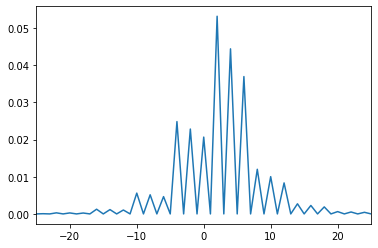

In [16]:
TR_ref = 6e-3
TR_list_ref = [TR_ref*1e3] * Nr
TE_ref = TR_ref/2
T2s_ref = 33
T2p_ref = 1/((1000/T2s)-1/T2)

off_resonance_f, M_transverse =  blochc(off_res, off_res_samplesize, M0 = M0 , alpha = alpha, phi = phi, dphi = dphi, TR= TR_list_ref, TE= TE_ref*1e3, T1 = T1*1e3, T2 = T2*1e3)
F_magnitude_inhomo, F_state = AddfieldInhomogeneous(M_transverse, TR_ref, TE_ref, T2p_ref, off_resonance_f)

plt.plot(F_state, np.absolute(F_magnitude_inhomo[0,:]))
plt.xlim(-25, 25)
F0_ref = np.abs(F_magnitude_inhomo[0,np.where(F_state == float(2))])

In [17]:
F0_ref

array([[0.05317041]])

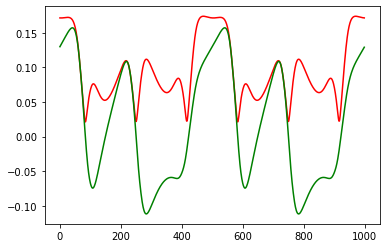

In [39]:
#plt.plot(np.real(M_transverse_new[0,:]),'b')
plt.plot(np.abs(M_transverse),'r')

plt.plot(np.real(M_transverse),'g')
#plt.plot(np.real(M_transverse_new[0,:]),'b')

In [40]:
F = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(M_transverse), axis = 0))

In [41]:
np.shape(F)

(1000, 1)

(490.0, 510.0)

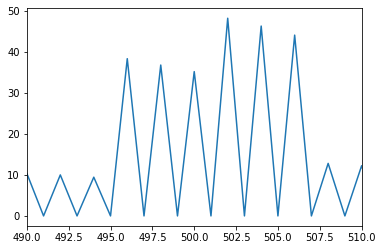

In [42]:
plt.plot(np.abs(F))
plt.xlim(490,510)